# Q3 AutoEncoders

## 3.1 Part-1 : AutoEncoders for Image Reconstruction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import hashlib
import os
import time
import datetime
from tqdm import tqdm
from sklearn.datasets import fetch_openml

from skimage.io import imread
from skimage.color import rgb2gray
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from skimage.transform import resize

In [2]:
# Using SHA-256 to generate unique seed
username = "m.samartha"
seed = int( hashlib.sha256(username.encode()).hexdigest(),16) % (2**32)
print(seed)
np.random.seed(seed)

def add_username(username = "m.samartha") -> None:
    plt.text(0.95, 0.95, username, ha="right", va="top", transform=plt.gca().transAxes, fontsize=10, color="gray", alpha=0.7)

def add_username_fig(username = "m.samartha", fig=None) -> None:
    if fig is None:
        fig = plt.gcf()
    fig.text(
        0.97, 0.97, "m.samartha",
        ha='right', va='top',
        fontsize=10, color='gray', alpha=0.7
    )

2669878649


#### Activation Functions

In [3]:
class Activation:
    """This is an abstract base class or an "interface". 
    It serves as a blueprint for all other activation functions."""
    # Cannot be instantiated directly
    def forward(self, x):
        raise NotImplementedError

    def backward(self, grad_output):
        raise NotImplementedError

# Each of the following classes inherit from Activation and implement its methods
# During the forward pass, we store any necessary intermediate values
# During the backward pass, we use these stored values to compute gradients
class ReLU(Activation):
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)

    def backward(self, grad_output):
        return grad_output * (self.x > 0)

class Tanh(Activation):
    def forward(self, x):
        self.out = np.tanh(x)
        return self.out

    def backward(self, grad_output):
        return grad_output * (1 - self.out ** 2)

class Sigmoid(Activation):
    def forward(self, x):
        self.out = 1 / (1 + np.exp(-x))
        return self.out

    def backward(self, grad_output):
        return grad_output * self.out * (1 - self.out)

class Identity(Activation):
    def forward(self, x):
        return x

    def backward(self, grad_output):
        return grad_output

#### Linear Layer

In [4]:
class Linear:
    """
    Implements a fully connected layer with support for activation.
    Stores parameters, intermediate values, and accumulated gradients.
    """

    def __init__(self, in_features, out_features, activation=None):
        """in_features: input dimension
           out_features: output dimension
           activation: instance of Activation class (e.g., ReLU(), Sigmoid())
        """
        self.in_features = in_features
        self.out_features = out_features
        self.activation = activation or Identity() # Default to Identity if no activation provided

        # Xavier initialization 
        limit = np.sqrt(6 / (in_features + out_features))
        self.weights = np.random.uniform(-limit, limit, (out_features, in_features))
        self.biases = np.zeros((out_features, 1))

        # Gradient accumulators
        self.grad_w = np.zeros_like(self.weights)
        self.grad_b = np.zeros_like(self.biases)

    def forward(self, x):
        """Forward pass through linear + activation."""
        self.input = x
        self.linear_output = np.dot(self.weights, x) + self.biases
        self.output = self.activation.forward(self.linear_output)
        return self.output
    
    def backward(self, grad_output):
        """Backward pass: compute gradients wrt weights, biases, and input."""
        grad_act = self.activation.backward(grad_output)

        # Gradients for weights and biases
        self.grad_w += np.dot(grad_act, self.input.T)
        self.grad_b += np.sum(grad_act, axis=1, keepdims=True)

        # Gradient wrt input (to pass to previous layer)
        grad_input = np.dot(self.weights.T, grad_act)
        return grad_input

    def zero_grad(self):
        """Reset accumulated gradients."""
        self.grad_w.fill(0)
        self.grad_b.fill(0)

    def update_params(self, lr):
        """Apply accumulated gradients and reset."""
        self.weights -= lr * self.grad_w
        self.biases -= lr * self.grad_b
        self.zero_grad()

#### Model Class

In [5]:
class Model:
    """
    Model that stacks multiple Linear layers and handles
    forward/backward passes, loss computation, and parameter updates.
    """

    def __init__(self, layers, loss_type="mse"):
        self.layers = layers
        if loss_type.lower() not in ["mse", "bce"]:
            raise ValueError("loss_type must be 'mse' or 'bce'")
        self.loss_type = loss_type.lower()

    def forward(self, x):
        """Run forward pass through all layers."""
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def compute_loss(self, y_pred, y_true):
        """Compute loss and gradient wrt output."""
        
        if self.loss_type == "mse":
            loss = np.mean((y_pred - y_true) ** 2)
            grad = 2 * (y_pred - y_true) / y_true.size

        elif self.loss_type == "bce":
            eps = 1e-8 # for numerical stability
            loss = -np.mean(y_true * np.log(y_pred + eps) + (1 - y_true) * np.log(1 - y_pred + eps))
            grad = (y_pred - y_true) / ((y_pred * (1 - y_pred) + eps) * y_true.size)
        return loss, grad

    def backward(self, grad_output):
        """Run backward pass through all layers (in reverse order)."""
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output)
        return grad_output

    def train_step(self, x, y):
        """Single forward+backward pass; accumulate gradients."""
        y_pred = self.forward(x)
        loss, grad_loss = self.compute_loss(y_pred, y)
        self.backward(grad_loss)
        return loss

    def zero_grad(self):
        """Reset all gradients."""
        for layer in self.layers:
            layer.zero_grad()

    def update(self, lr):
        """Update model parameters and reset grads."""
        for layer in self.layers:
            layer.update_params(lr)

    def predict(self, x):
        """Forward pass for inference."""
        return self.forward(x)

    def save_to(self, path):
        """Save all parameters to .npz file."""
        params = {}
        for i, layer in enumerate(self.layers):
            params[f"W{i}"] = layer.weights
            params[f"b{i}"] = layer.biases
        np.savez(path, **params)

    def load_from(self, path):
        """Load parameters from .npz file (check shapes)."""
        data = np.load(path)
        for i, layer in enumerate(self.layers):
            W, b = data[f"W{i}"], data[f"b{i}"]
            if W.shape != layer.weights.shape or b.shape != layer.biases.shape:
                raise ValueError(f"Shape mismatch in layer {i}")
            layer.weights, layer.biases = W, b

### 3.1.1 AutoEncoder Implementation

#### MLPAutoEncoder Class

In [6]:
class MLPAutoencoder:
    """
    An MLP-based Autoencoder class.
    It encapsulates an encoder and a decoder.
    """ 
    def __init__(self, encoder_layers, decoder_layers, loss_type='mse'):
        """
        Initializes the autoencoder by creating separate Model instances
        for the encoder and decoder.

        Args:
            encoder_layers (list): A list of Linear layer objects for the encoder.
            decoder_layers (list): A list of Linear layer objects for the decoder.
            loss_fn_type (str): The type of loss function to use ('mse' or 'bce').
        """
        # The encoder compresses the input to a lower-dimensional bottleneck
        self.encoder = Model(encoder_layers, loss_type=loss_type)
        
        # The decoder reconstructs the input from the bottleneck representation
        self.decoder = Model(decoder_layers, loss_type=loss_type)
    
    def forward(self, x):
        """Performs a full forward pass through the encoder and then the decoder."""
        encoded_representation = self.encoder.predict(x)
        reconstructed_output = self.decoder.predict(encoded_representation)
        return reconstructed_output
    
    def train(self, x):
        """
        Performs one full training step on an input batch 'x'.
        The goal is to reconstruct 'x', so the input and target are the same.
        """
        # Get the reconstructed output from the forward pass
        y_pred = self.forward(x)

        # Calculate the reconstruction loss and its initial gradient
        loss, grad_loss = self.decoder.compute_loss(y_pred, x)

        # Perform the backward pass
        # 1. Backpropagate through the decoder
        grad_from_decoder = self.decoder.backward(grad_loss)
        # 2. Backpropagate the resulting gradient through the encoder
        _ = self.encoder.backward(grad_from_decoder)
        
        return loss
    
    def zero_grad(self):
        """Resets accumulated gradients in both the encoder and decoder."""
        self.encoder.zero_grad()
        self.decoder.zero_grad()

    def update(self, learning_rate):
        """Updates parameters for both the encoder and decoder and resets gradients."""
        self.encoder.update(learning_rate)
        self.decoder.update(learning_rate)

### 3.1.2  Training and Visualization on MNIST

In [34]:
print("Fetching MNIST dataset using fetch_openml...")
mnist = fetch_openml('mnist_784', version=1, as_frame=True, parser='auto')

# X contains the image data (as a Pandas DataFrame)
# y contains the labels (as a Pandas Series)
X, y = mnist.data, mnist.target

X = X.to_numpy()
y = y.to_numpy()

# Normalize the pixel values to the range [0, 1]
X = X.astype('float32') / 255.0

# Split into training and testing sets (the first 60k are train, last 10k are test)
x_train, x_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

print(f"\nTraining data shape: {x_train.shape}")
print(f"Testing data shape: {x_test.shape}")

Fetching MNIST dataset using fetch_openml...

Training data shape: (60000, 784)
Testing data shape: (10000, 784)


In [8]:
# Define the architecture for the autoencoder
input_size = 28*28
bottleneck_dim = 32

# Define the layers for the encoder and decoder
encoder_layers = [
    Linear(in_features=input_size, out_features=256, activation=ReLU()),
    Linear(in_features=256, out_features=128, activation=ReLU()),
    Linear(in_features=128, out_features=64, activation=ReLU()),
    Linear(in_features=64, out_features=bottleneck_dim, activation=ReLU())
]

decoder_layers = [
    Linear(in_features=bottleneck_dim, out_features=64, activation=ReLU()),
    Linear(in_features=64, out_features=128, activation=ReLU()),
    Linear(in_features=128, out_features=256, activation=ReLU()),
    Linear(in_features=256, out_features=input_size, activation=Sigmoid()) # Sigmoid activation to output values in [0, 1]
]

# Create the autoencoder instance
autoencoder_mnist = MLPAutoencoder(encoder_layers, decoder_layers, loss_type='mse')

#### Training loop

In [7]:
def train_autoencoder(autoencoder, x_train, epochs=10, batch_size=64, learning_rate=0.025,
                      patience=10, relative_loss_threshold=0.01, seed=seed, run_dir=None):
    """
    Implements the full training loop for the autoencoder with loss plotting and early stopping.
    
    Args:
        autoencoder: The autoencoder model
        x_train: Training data (n_samples, n_features)
        epochs: Number of training epochs
        batch_size: Size of each batch
        learning_rate: Learning rate for optimization
        patience: Number of epochs to wait before early stopping
        relative_loss_threshold: Relative improvement threshold for early stopping
        seed: Random seed for reproducibility
        run_dir: Directory to save training artifacts (plots, model checkpoints)
    
    Returns:
        autoencoder: Trained model
        run_folder: Path to the run folder
        final_loss: Final average epoch loss
        total_samples_seen: Total number of samples processed
        training_duration: Time taken for training
    """
    run_folder = run_dir
    os.makedirs(run_folder, exist_ok=True)
    np.random.seed(seed)

    start_time = time.time()

    loss_history = []
    samples_seen_history = []
    epoch_loss_history = []
    total_samples_seen = 0

    pbar = tqdm(range(epochs), desc="Training", unit="epoch")
    # Main training loop
    try:
        for epoch in range(epochs):
            epoch_loss = 0
            
            # Shuffle the training data before each epoch
            permutation = np.random.permutation(x_train.shape[0])
            x_train_shuffled = x_train[permutation]
            
            num_samples = x_train_shuffled.shape[0]
            num_batches = num_samples // batch_size
            
            # Use tqdm only if flag is True
            iterator = range(num_batches)

            for i in range(0, num_samples, batch_size):
                batch_X = x_train_shuffled[i:i + batch_size].T
                
                loss = autoencoder.train(batch_X)
                epoch_loss += loss
                autoencoder.update(learning_rate)

                loss_history.append(loss)
                total_samples_seen += len(batch_X.T)
                samples_seen_history.append(total_samples_seen)

            # Average epoch loss
            avg_epoch_loss = epoch_loss / num_batches
            epoch_loss_history.append(avg_epoch_loss)
            final_loss = avg_epoch_loss
            
            pbar.set_postfix({"loss": f"{avg_epoch_loss:.4f}"})
            pbar.update(1)

            # Early Stopping
            if epoch >= patience:
                past_loss = epoch_loss_history[epoch - patience]
                if avg_epoch_loss >= (1.0 - relative_loss_threshold) * past_loss:
                    pbar.write(f"\nEarly stopping triggered at epoch {epoch + 1}") # Writes to console without breaking progress bar
                    break
    finally:
        pbar.close()

    end_time = time.time()
    training_duration = end_time - start_time
    
    # Plot loss vs. samples seen
    plt.figure(figsize=(10, 5))
    plt.plot(samples_seen_history, loss_history)
    plt.title("Training Loss vs. Samples Seen")
    plt.xlabel("Number of Samples Seen")
    plt.ylabel("Loss")
    plt.grid(True)
    add_username()
    loss_plot_path = os.path.join(run_folder, "loss_plot.png")
    plt.savefig(loss_plot_path)
    plt.show()    # Show the plot
    print(f"Loss plot saved to {loss_plot_path}")
    
    # Print summary
    print(f"\nTraining completed in {training_duration:.2f} seconds")
    print(f"Final loss: {final_loss:.6f}")
    print(f"Total samples seen: {total_samples_seen}")
    
    return autoencoder, final_loss, total_samples_seen, training_duration

Training: 100%|██████████| 100/100 [19:55<00:00, 11.95s/epoch, loss=0.0163]


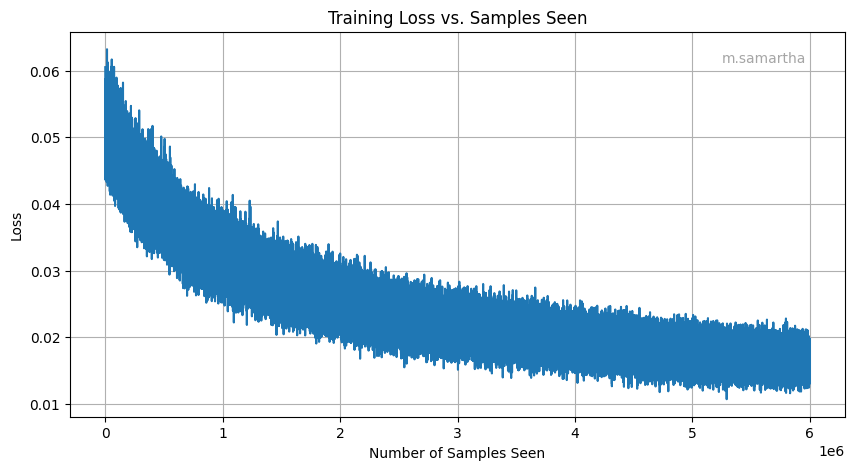

Loss plot saved to Q3/3_1/loss_plot.png

Training completed in 1195.07 seconds
Final loss: 0.016293
Total samples seen: 6000000


In [29]:
run_folder_MNIST = "Q3/3_1"

autoencoder_mnist, final_loss_mnist, total_samples_mnist, duration_mnist = train_autoencoder(
    autoencoder=autoencoder_mnist,
    x_train=x_train,
    epochs=100,
    batch_size=32,
    learning_rate=0.1,
    patience=10,
    relative_loss_threshold=0.01,
    seed=seed,
    run_dir=run_folder_MNIST
)

#### Visualization

In [35]:
def visualize(autoencoder, x_test, y_test, num_digits=10, seed=seed):
    """
    Visualizes the results of an autoencoder by showing original and reconstructed images.
    
    Args:
        autoencoder: The trained autoencoder model
        x_test: Test data (images)
        y_test: Test labels
        num_digits: Number of digits to display (default: 10)
        seed: Random seed for reproducibility
        
    Returns:
        fig: The matplotlib figure object
    """
    np.random.seed(seed)
        
    indices = []
    
    for digit in range(10):
        digit_indices = np.where(y_test.astype(int) == digit)[0]
        if len(digit_indices) > 0:
            indices.append(np.random.choice(digit_indices))
    
    # Get originals and reconstructions
    originals = x_test[indices]
    reconstructed = autoencoder.forward(originals.T).T
    
    # Calculate reconstruction error for each image
    reconstruction_errors = np.mean((originals - reconstructed)**2, axis=1)
    
    # Plot
    fig, axes = plt.subplots(2, num_digits, figsize=(16, 5))
    fig.suptitle("Original vs. Reconstructed Images (MSE shown)", fontsize=16)
    
    for i in range(num_digits):
        digit = int(y_test[indices[i]])
        error = reconstruction_errors[i]
        
        # Original
        axes[0, i].imshow(originals[i].reshape(28, 28), cmap='gray', vmin=0, vmax=1)
        axes[0, i].set_title(f"Original: {digit}")
        axes[0, i].axis('off')
        
        # Reconstructed
        axes[1, i].imshow(reconstructed[i].reshape(28, 28), cmap='gray', vmin=0, vmax=1)
        axes[1, i].set_title(f"Recon(err:{error:.4f})")
        axes[1, i].axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    add_username_fig(fig=fig)
    plt.show()

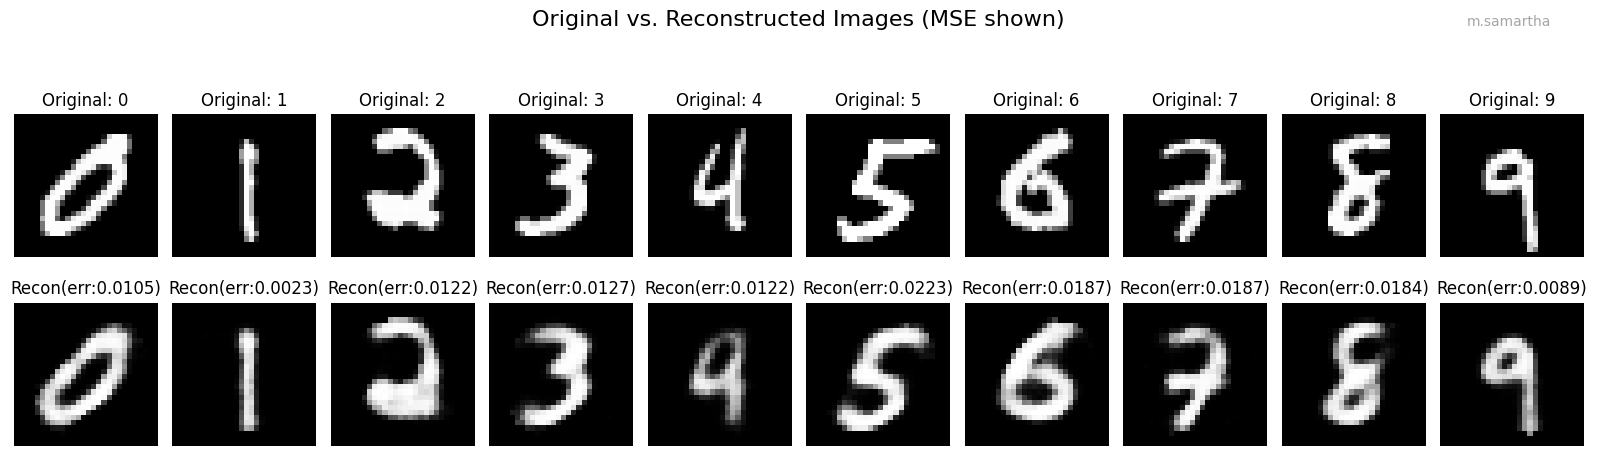

In [36]:
visualize(autoencoder_mnist, x_test, y_test, num_digits=10, seed=seed)

## 3.2 Part 2: Anomaly Detection with Autoencoders 

### 3.2.1 Anamoly Detection

#### Dataset Preparation and Visualization

In [9]:
def load_anomaly_data(seed=seed):
    """
    Loads LFW dataset for anomaly detection.
    Training: 80% of George W Bush images
    Test: 20% of George W Bush + all other images
    
    Returns:
        X_train: Training images (80% of George W Bush only)
        X_test: Test images (20% George W Bush + all others)
        y_test: Binary labels (0=normal/George W Bush, 1=anomaly)
    """

    # Load full dataset
    lfw_people = fetch_lfw_people(
        min_faces_per_person=0,
        resize=1,
        color=False  # Grayscale images
    )
    
    # Extract images, labels, and person names
    X = lfw_people.images          # Shape: (n_samples, height, width)
    y = lfw_people.target          # Person ID for each image
    target_names = lfw_people.target_names 

    # Resize images to 250x250
    n_samples = X.shape[0]
    X_resized = np.zeros((n_samples, 250, 250))
    
    for i in range(n_samples):
        X_resized[i] = resize(X[i], (250, 250), anti_aliasing=True)
    
    # Update X to use resized images
    X = X_resized
    print(f"Sample image shape: {X[0].shape}, Target: {y[0]}, Target Name: {target_names[y[0]]}")

    # Flatten images for the autoencoder (from shape (h, w) to (h*w,))
    n_samples, h, w = X.shape
    print(f"Total images: {n_samples}, Image dimensions: ({h}, {w})")
    print(f"Number of unique people: {len(target_names)}")
    X_flattened = X.reshape((n_samples, h * w))
    X = X_flattened

    # Find the index of 'George W Bush' in the target_names list
    bush_idx = np.where(target_names == 'George W Bush')[0][0]
    
    # Split data
    X_bush = X[y == bush_idx]
    X_others = X[y != bush_idx]
    
    print(f"George W Bush images: {len(X_bush)}")
    print(f"Other people's images: {len(X_others)}")

    # Training set: 80% of George W Bush images
    # Test set: Remaining 20% Bush + 10% of all other people
    # 10% of others images
    X_train, X_bush_test = train_test_split(
        X_bush, 
        test_size=0.2,      
        random_state=seed   
    )
    
    X_train = X_bush
    
    X_others, _ = train_test_split(
        X_others, 
        test_size=0.9,      
        random_state=seed  
    )
    
    # Stack vertically to combine arrays
    X_test = np.vstack([X_bush_test, X_others])

    # Create binary labels for test set
    # 0 = normal (George W Bush), 1 = anomaly (others)
    y_test = np.hstack([
        np.zeros(len(X_bush_test)),  
        np.ones(len(X_others))       
    ])
    
    # Shuffle to mix normal and anomaly samples randomly
    perm = np.random.RandomState(seed).permutation(len(X_test))
    
    X_test = X_test[perm]
    y_test = y_test[perm]
    
    # ========== Summary ==========
    print(f"\n{'='*50}")
    print(f"DATASET SUMMARY")
    print(f"{'='*50}")
    print(f"Training set:")
    print(f"  - Size: {len(X_train)} (George W Bush images)")
    print(f"  - Class: Normal only (George W Bush)")
    print(f"\nTest set:")
    print(f"  - Total size: {len(X_test)}")
    print(f"  - Normal samples (label=0): {np.sum(y_test == 0)}")
    print(f"  - Anomaly samples (label=1): {np.sum(y_test == 1)}")
    print(f"{'='*50}\n")

    return X_train, X_test, y_test


In [10]:
X_train, X_test, y_test = load_anomaly_data(seed=seed)  

Sample image shape: (250, 250), Target: 5360, Target Name: Tim Curry
Total images: 13233, Image dimensions: (250, 250)
Number of unique people: 5749
George W Bush images: 530
Other people's images: 12703

DATASET SUMMARY
Training set:
  - Size: 530 (George W Bush images)
  - Class: Normal only (George W Bush)

Test set:
  - Total size: 1376
  - Normal samples (label=0): 106
  - Anomaly samples (label=1): 1270



In [11]:
def visualize_anomaly_dataset(X_train, X_test, y_test, n_samples=5):
    """
    Visualizes samples from the anomaly detection dataset.
    
    Shows:
    - Training samples (all normal/George W Bush)
    - Test normal samples (George W Bush)
    - Test anomaly samples (other people)
    
    Args:
        X_train (np.ndarray): Training images
        X_test (np.ndarray): Test images
        y_test (np.ndarray): Test labels (0=normal, 1=anomaly)
        n_samples (int): Number of samples to display per row
    """
    img_size = int(np.sqrt(X_train.shape[1]))
    if img_size * img_size != X_train.shape[1]:
        # If not square, try common aspect ratios
        h, w = 250, 250
        if h * w == X_train.shape[1]:
            img_size = (h, w)
        else:
            img_size = (img_size, img_size)
    else:
        img_size = (img_size, img_size)
    
    # Select samples
    train_samples = X_train[:n_samples]
    
    # Get normal and anomaly test samples
    normal_mask = (y_test == 0)
    anomaly_mask = (y_test == 1)
    
    test_normal_samples = X_test[normal_mask][:n_samples]
    test_anomaly_samples = X_test[anomaly_mask][:n_samples]
    
    # Create visualization
    fig, axes = plt.subplots(3, n_samples, figsize=(15, 9))
    fig.suptitle('Dataset Visualization', fontsize=16, y=0.98)
    
    # Row 1: Training samples (all George W Bush)
    for i in range(n_samples):
        axes[0, i].imshow(train_samples[i].reshape(img_size), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Training\n(Normal)', fontsize=10, fontweight='bold')
        else:
            axes[0, i].set_title('Training', fontsize=10)
    
    # Row 2: Test normal samples (George W Bush)
    for i in range(n_samples):
        axes[1, i].imshow(test_normal_samples[i].reshape(img_size), cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Test Normal\n(Label=0)', fontsize=10, fontweight='bold', color='green')
        else:
            axes[1, i].set_title('Test Normal', fontsize=10, color='green')
    
    # Row 3: Test anomaly samples (other people)
    for i in range(n_samples):
        axes[2, i].imshow(test_anomaly_samples[i].reshape(img_size), cmap='gray')
        axes[2, i].axis('off')
        if i == 0:
            axes[2, i].set_title('Test Anomaly\n(Label=1)', fontsize=10, fontweight='bold', color='red')
        else:
            axes[2, i].set_title('Test Anomaly', fontsize=10, color='red')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    add_username_fig(fig=fig)    
    plt.show()

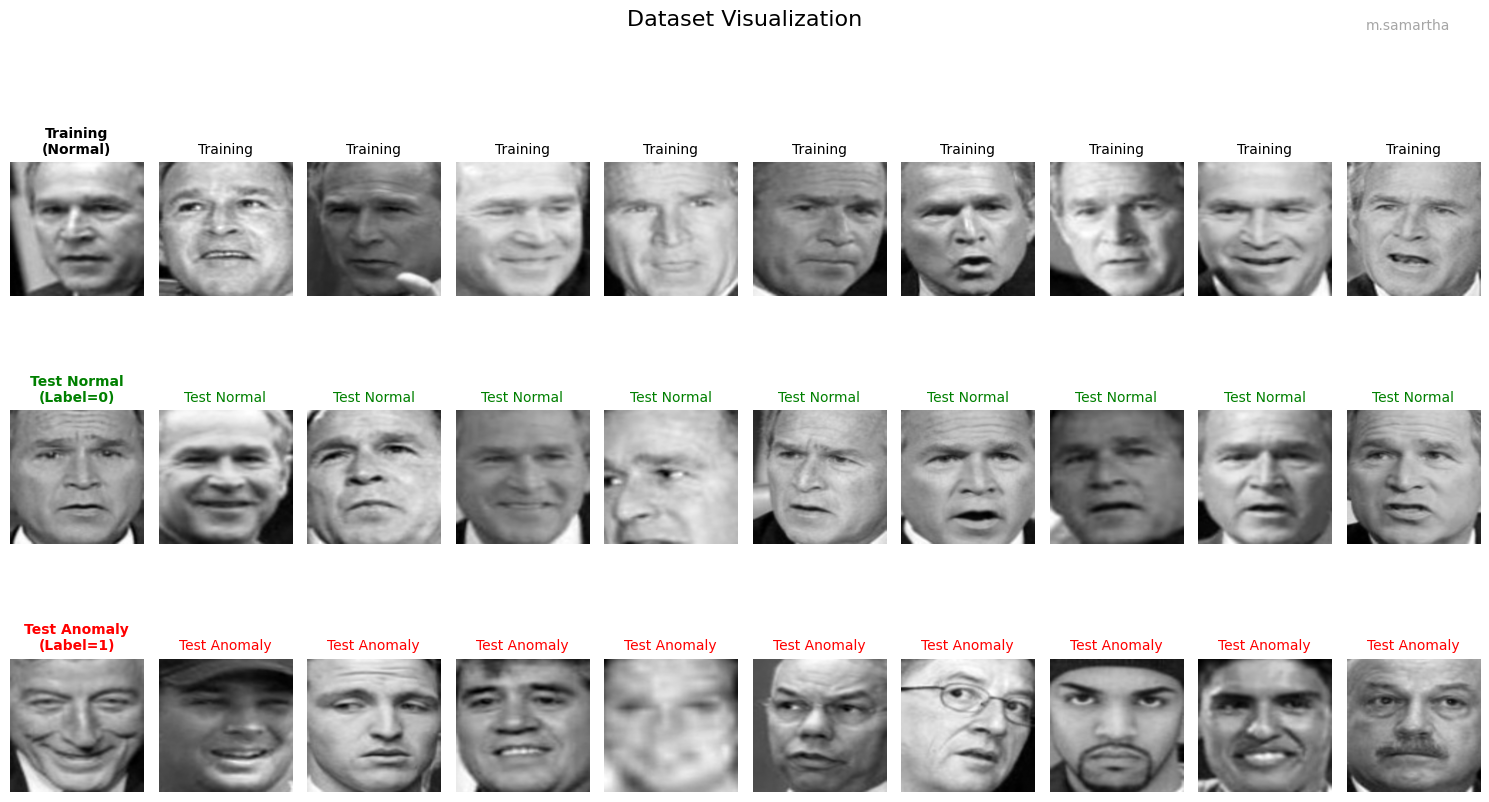

In [12]:
visualize_anomaly_dataset(X_train, X_test, y_test, n_samples=10)

#### Training on Normal Data

In [13]:
# Image dimensions for LFW with resize=1
input_size = 250 * 250

# Bottleneck dimension (compressed representation)
bottleneck_dim = 128

# ENCODER: Gradually compress the face image
# Architecture: 62500 -> 2048 -> 1024 -> 512 -> 256 -> 128
encoder_layers = [
    Linear(in_features=input_size, out_features=2500, activation=Tanh()),
    Linear(in_features=2500, out_features=1000, activation=Tanh()),
    Linear(in_features=1000, out_features=bottleneck_dim, activation=Tanh())
]

# DECODER: Mirror encoder to reconstruct the face
# Architecture: 128 -> 256 -> 512 -> 1024 -> 2048 -> 62500
decoder_layers = [
    Linear(in_features=bottleneck_dim, out_features=500, activation=Tanh()),
    Linear(in_features=500, out_features=2500, activation=Tanh()),
    Linear(in_features=2500, out_features=input_size, activation=Sigmoid())  # Sigmoid for [0,1] output
]

# Create autoencoder instance
autoencoder_gwb_128 = MLPAutoencoder(encoder_layers, decoder_layers, loss_type='mse')

print(f"Autoencoder Architecture:")
print(f"  Input size: {input_size} features")
print(f"  Bottleneck: {bottleneck_dim} features")
print(f"  Compression ratio: {input_size / bottleneck_dim:.1f}x")

Autoencoder Architecture:
  Input size: 62500 features
  Bottleneck: 128 features
  Compression ratio: 488.3x


In [16]:
def save_to(path, autoencoder):
    """
    Saves all autoencoder parameters (encoder + decoder) to a .npz file.
    
    Args:
        path (str): File path where the model will be saved (e.g., 'autoencoder.npz').
    """
    params = {}
    
    # Save encoder parameters with 'enc_' prefix
    for i, layer in enumerate(autoencoder.encoder.layers):
        params[f'enc_w_{i}'] = layer.weights
        params[f'enc_b_{i}'] = layer.biases
    
    # Save decoder parameters with 'dec_' prefix
    for i, layer in enumerate(autoencoder.decoder.layers):
        params[f'dec_w_{i}'] = layer.weights
        params[f'dec_b_{i}'] = layer.biases
    
    np.savez(path, **params)
    print(f"Autoencoder saved to {path}")

Training: 100%|██████████| 75/75 [29:55<00:00, 23.94s/epoch, loss=0.0221]


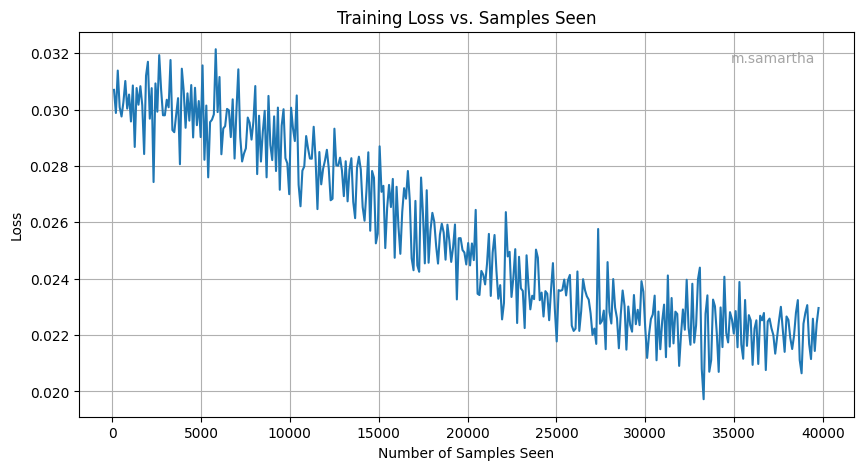

Loss plot saved to Q3/3_2/gwb_128/loss_plot.png

Training completed in 1795.64 seconds
Final loss: 0.022106
Total samples seen: 39750

TRAINING COMPLETE
Final Loss: 0.022106
Total Samples: 39750
Duration: 1795.64s
Run folder: Q3/3_2/gwb_128


In [14]:
run_folder_gwb_128 = "Q3/3_2/gwb_128"

autoencoder_gwb_128, final_loss_gwb_128, total_samples_gwb_128, duration_gwb_128 = train_autoencoder(
    autoencoder=autoencoder_gwb_128,
    x_train=X_train,  # Use the loaded training data (George W Bush only)
    epochs=75,
    batch_size=106,           # Smaller batch for larger images
    learning_rate=5,     # Lower LR for stability (NOT 0.1!)
    patience=100,             # More patience for face reconstruction
    relative_loss_threshold=0.01,  # Stricter stopping criterion
    seed=seed,
    run_dir=run_folder_gwb_128
)

print(f"\n{'='*50}")
print(f"TRAINING COMPLETE")
print(f"{'='*50}")
print(f"Final Loss: {final_loss_gwb_128:.6f}")
print(f"Total Samples: {total_samples_gwb_128}")
print(f"Duration: {duration_gwb_128:.2f}s")
print(f"Run folder: {run_folder_gwb_128}")

In [ ]:
save_to(os.path.join(run_folder_gwb_128, "autoencoder_gwb_128.npz"), autoencoder_gwb_128)

Autoencoder saved to Q3/3_2/gwb_128/autoencoder_gwb_128.npz


In [18]:
def visualize_faces(autoencoder, X_test, y_test=None, num_normal=5, num_anomaly=5, seed=42):
    """
    Visualizes the original and reconstructed face images from the autoencoder with proper display.
    
    Args:
        autoencoder: The trained autoencoder model
        X_test: Test data (face images)
        y_test: Test labels (0=normal/George W Bush, 1=anomaly) (optional)
        num_normal: Number of normal examples to show
        num_anomaly: Number of anomaly examples to show
        seed: Random seed for reproducibility
        
    Returns:
        fig: The matplotlib figure object
    """
    
    # LFW image dimensions
    img_height, img_width = 250, 250
    
    # Select samples to display
    if y_test is not None:
        # If labels provided, get both normal and anomaly samples
        normal_indices = np.where(y_test == 0)[0]
        anomaly_indices = np.where(y_test == 1)[0]
        
        if len(normal_indices) > 0 and len(anomaly_indices) > 0:
            # Randomly sample from each class
            normal_samples = np.random.choice(normal_indices, min(num_normal, len(normal_indices)), replace=False)
            anomaly_samples = np.random.choice(anomaly_indices, min(num_anomaly, len(anomaly_indices)), replace=False)
            
            # Combine indices
            indices = np.concatenate([normal_samples, anomaly_samples])
            
            # Create labels for display
            labels = ['Normal'] * len(normal_samples) + ['Anomaly'] * len(anomaly_samples)
            colors = ['green'] * len(normal_samples) + ['red'] * len(anomaly_samples)
        else:
            # Fallback if no labels or only one class
            indices = np.random.choice(len(X_test), min(num_normal + num_anomaly, len(X_test)), replace=False)
            labels = [''] * len(indices)
            colors = ['black'] * len(indices)
    else:
        # No labels provided, just sample randomly
        indices = np.random.choice(len(X_test), min(num_normal + num_anomaly, len(X_test)), replace=False)
        labels = [''] * len(indices)
        colors = ['black'] * len(indices)
    
    # Determine number of rows needed
    n_samples = len(indices)
    
    fig, axes = plt.subplots(n_samples, 2, figsize=(10, 3 * n_samples))
    
    # Handle case with just one sample
    if n_samples == 1:
        axes = axes.reshape(1, 2)
    
    # Main title
    fig.suptitle("Original vs. Reconstructed Face Images", fontsize=16)
    
    # Plot each sample
    for i in range(n_samples):
        # Get original sample
        original = X_test[indices[i]]
        
        # Get reconstruction - need to pass as batch (add dimension)
        reconstruction = autoencoder.forward(original.reshape(1, -1).T).T
        
        # Reshape images to 2D for display
        orig_img = original.reshape(img_height, img_width)
        recon_img = reconstruction.reshape(img_height, img_width)
        
        # Calculate reconstruction error (MSE)
        error = np.mean((original - reconstruction.flatten())**2)
        
        # Original
        axes[i, 0].imshow(orig_img, cmap='gray')
        if labels[i]:
            axes[i, 0].set_title(f"Original: {labels[i]}", color=colors[i])
        else:
            axes[i, 0].set_title("Original")
        axes[i, 0].axis('off')
        
        # Reconstructed
        axes[i, 1].imshow(recon_img, cmap='gray')
        axes[i, 1].set_title(f"Reconstructed (Error: {error:.4f})")
        axes[i, 1].axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    add_username_fig(fig=fig)
    plt.show()

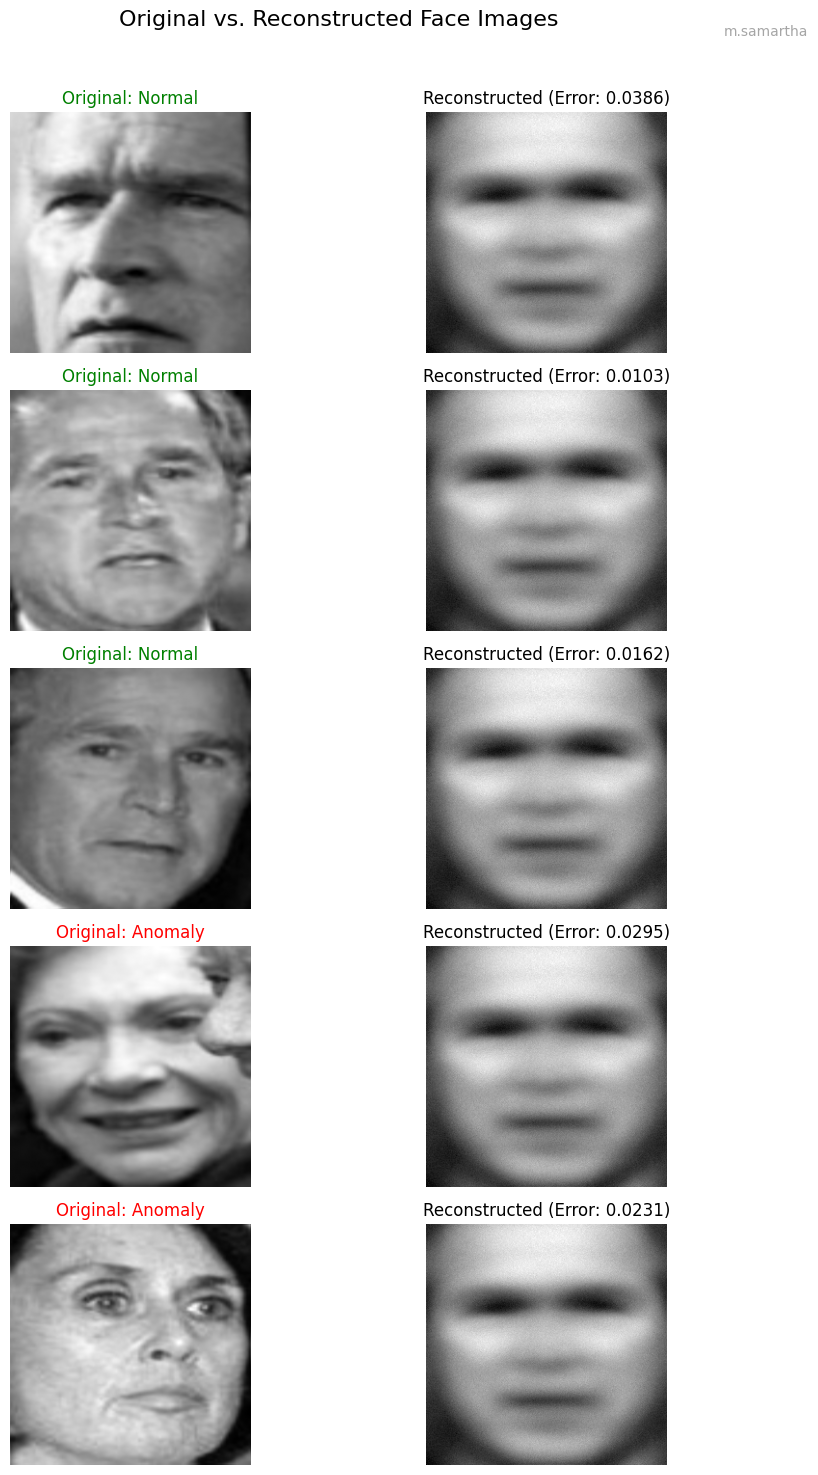

In [19]:
visualize_faces(autoencoder_gwb_128, X_test, y_test, num_normal=3, num_anomaly=2)

#### Evaluation

In [20]:
from sklearn.metrics import (
    roc_auc_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_curve,
    precision_recall_curve,
    confusion_matrix
)

def calculate_reconstruction_errors(autoencoder, X_test, batch_size=256):
    """
    Calculate reconstruction error (MSE) for each test image in batches.
    
    Args:
        autoencoder: Trained autoencoder model
        X_test: Test images, shape (n_samples, n_features)
        batch_size: Number of images to process at once (default=256)
    
    Returns:
        reconstruction_errors: MSE for each image, shape (n_samples,)
    """
    print(f"Calculating reconstruction errors in batches of {batch_size}...")
    
    n_samples = X_test.shape[0]
    reconstruction_errors = np.zeros(n_samples)
    
    # Process in batches to avoid memory issues
    for i in range(0, n_samples, batch_size):
        end_idx = min(i + batch_size, n_samples)
        batch = X_test[i:end_idx]
        
        # Get reconstructions for this batch
        batch_reconstructed = autoencoder.forward(batch.T).T
        
        # Calculate MSE for each image in batch
        batch_errors = np.mean((batch - batch_reconstructed) ** 2, axis=1)
        reconstruction_errors[i:end_idx] = batch_errors
        
        if (i // batch_size) % 10 == 0:
            print(f"  Processed {end_idx}/{n_samples} images...")
    
    print(f"Reconstruction errors calculated for {len(X_test)} images")
    print(f"  Min error: {reconstruction_errors.min():.6f}")
    print(f"  Max error: {reconstruction_errors.max():.6f}")
    print(f"  Mean error: {reconstruction_errors.mean():.6f}")
    
    return reconstruction_errors

def find_optimal_threshold(reconstruction_errors, y_test, method='youden'):
    """
    Find optimal threshold for anomaly classification.
    
    Args:
        reconstruction_errors: Reconstruction errors for test set
        y_test: True labels (0=normal, 1=anomaly)
        method: 'youden' (Youden's J statistic) or 'percentile'
    
    Returns:
        optimal_threshold: Threshold value
    """
    if method == 'youden':
        # Use Youden's J statistic (maximizes TPR - FPR)
        fpr, tpr, thresholds = roc_curve(y_test, reconstruction_errors)
        j_scores = tpr - fpr
        optimal_idx = np.argmax(j_scores)
        optimal_threshold = thresholds[optimal_idx]
        
        print(f"\nOptimal threshold (Youden's J): {optimal_threshold:.6f}")
        print(f"  TPR at threshold: {tpr[optimal_idx]:.3f}")
        print(f"  FPR at threshold: {fpr[optimal_idx]:.3f}")
        
    elif method == 'percentile':
        # Use 95th percentile of normal class errors
        normal_errors = reconstruction_errors[y_test == 0]
        optimal_threshold = np.percentile(normal_errors, 95)
        
        print(f"\nOptimal threshold (95th percentile): {optimal_threshold:.6f}")
    
    return optimal_threshold

def evaluate_anomaly_detection(reconstruction_errors, y_test, threshold):
    """
    Evaluate anomaly detection performance using reconstruction errors.
    
    Args:
        reconstruction_errors: Reconstruction errors for test set
        y_test: True labels (0=normal, 1=anomaly)
        threshold: Classification threshold
    
    Returns:
        metrics: Dictionary containing all evaluation metrics
    """
    # Classify: error > threshold => anomaly (1), else normal (0)
    y_pred = (reconstruction_errors > threshold).astype(int)
    
    # Calculate metrics
    auc_score = roc_auc_score(y_test, reconstruction_errors)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Store results
    metrics = {
        'auc_score': auc_score,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'threshold': threshold,
        'true_positives': tp,
        'false_positives': fp,
        'true_negatives': tn,
        'false_negatives': fn,
        'y_pred': y_pred
    }
    
    return metrics

def print_evaluation_report(metrics):
    """
    Print a formatted evaluation report.
    
    Args:
        metrics: Dictionary containing evaluation metrics
    """
    print(f"\n{'='*60}")
    print(f"ANOMALY DETECTION EVALUATION REPORT")
    print(f"{'='*60}")
    print(f"\nClassification Threshold: {metrics['threshold']:.6f}")
    print(f"\n{'Metric':<20} {'Value':<10}")
    print(f"{'-'*30}")
    print(f"{'AUC Score':<20} {metrics['auc_score']:.4f}")
    print(f"{'Precision':<20} {metrics['precision']:.4f}")
    print(f"{'Recall':<20} {metrics['recall']:.4f}")
    print(f"{'F1-Score':<20} {metrics['f1_score']:.4f}")
    
    print(f"\n{'Confusion Matrix':<20}")
    print(f"{'-'*30}")
    print(f"{'True Positives':<20} {metrics['true_positives']:<10}")
    print(f"{'False Positives':<20} {metrics['false_positives']:<10}")
    print(f"{'True Negatives':<20} {metrics['true_negatives']:<10}")
    print(f"{'False Negatives':<20} {metrics['false_negatives']:<10}")
    print(f"{'='*60}\n")

def plot_error_distributions(reconstruction_errors, y_test, threshold):
    """
    Plot reconstruction error distributions for normal vs anomaly classes.
    
    Args:
        reconstruction_errors: Reconstruction errors for test set
        y_test: True labels (0=normal, 1=anomaly)
        threshold: Classification threshold
    """
    normal_errors = reconstruction_errors[y_test == 0]
    anomaly_errors = reconstruction_errors[y_test == 1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram
    ax1.hist(normal_errors, bins=50, alpha=0.7, label='Normal (George W Bush)', 
             color='green', edgecolor='black')
    ax1.hist(anomaly_errors, bins=50, alpha=0.7, label='Anomaly (Others)', 
             color='red', edgecolor='black')
    ax1.axvline(threshold, color='blue', linestyle='--', linewidth=2, 
                label=f'Threshold = {threshold:.4f}')
    ax1.set_xlabel('Reconstruction Error (MSE)', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.set_title('Reconstruction Error Distribution', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Box plot
    data_to_plot = [normal_errors, anomaly_errors]
    bp = ax2.boxplot(data_to_plot, labels=['Normal', 'Anomaly'], patch_artist=True)
    bp['boxes'][0].set_facecolor('green')
    bp['boxes'][1].set_facecolor('red')
    ax2.axhline(threshold, color='blue', linestyle='--', linewidth=2, 
                label=f'Threshold = {threshold:.4f}')
    ax2.set_ylabel('Reconstruction Error (MSE)', fontsize=12)
    ax2.set_title('Reconstruction Error by Class', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3, axis='y')
    
    plt.suptitle('Anomaly Detection: Error Analysis', fontsize=16, y=1.02)
    plt.tight_layout()
    add_username_fig(fig=fig)
    plt.show()

def plot_roc_curve(reconstruction_errors, y_test, metrics):
    """
    Plot ROC curve for anomaly detection.
    
    Args:
        reconstruction_errors: Reconstruction errors for test set
        y_test: True labels (0=normal, 1=anomaly)
        metrics: Dictionary containing evaluation metrics
    """
    fpr, tpr, thresholds = roc_curve(y_test, reconstruction_errors)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {metrics["auc_score"]:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
    
    # Mark optimal threshold point
    threshold_idx = np.argmin(np.abs(thresholds - metrics['threshold']))
    plt.scatter(fpr[threshold_idx], tpr[threshold_idx], color='red', s=100, 
                zorder=5, label=f'Threshold = {metrics["threshold"]:.4f}')
    
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve - Anomaly Detection', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    add_username()
    plt.tight_layout()
    plt.show()

In [22]:
# Step 1: Calculate reconstruction errors
reconstruction_errors = calculate_reconstruction_errors(autoencoder_gwb_128, X_test)

Calculating reconstruction errors in batches of 256...
  Processed 256/1376 images...
Reconstruction errors calculated for 1376 images
  Min error: 0.004339
  Max error: 0.112038
  Mean error: 0.028116


In [23]:
# Step 2: Find optimal threshold
threshold = find_optimal_threshold(reconstruction_errors, y_test, method='youden')


Optimal threshold (Youden's J): 0.021621
  TPR at threshold: 0.624
  FPR at threshold: 0.368


In [25]:
# Step 3: Evaluate with threshold
metrics = evaluate_anomaly_detection(reconstruction_errors, y_test, threshold)
# Step 4: Print results
print_evaluation_report(metrics)


ANOMALY DETECTION EVALUATION REPORT

Classification Threshold: 0.021621

Metric               Value     
------------------------------
AUC Score            0.6313
Precision            0.9531
Recall               0.6236
F1-Score             0.7539

Confusion Matrix    
------------------------------
True Positives       792       
False Positives      39        
True Negatives       67        
False Negatives      478       



/tmp/ipykernel_2097234/4118096148.py:177: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(data_to_plot, labels=['Normal', 'Anomaly'], patch_artist=True)


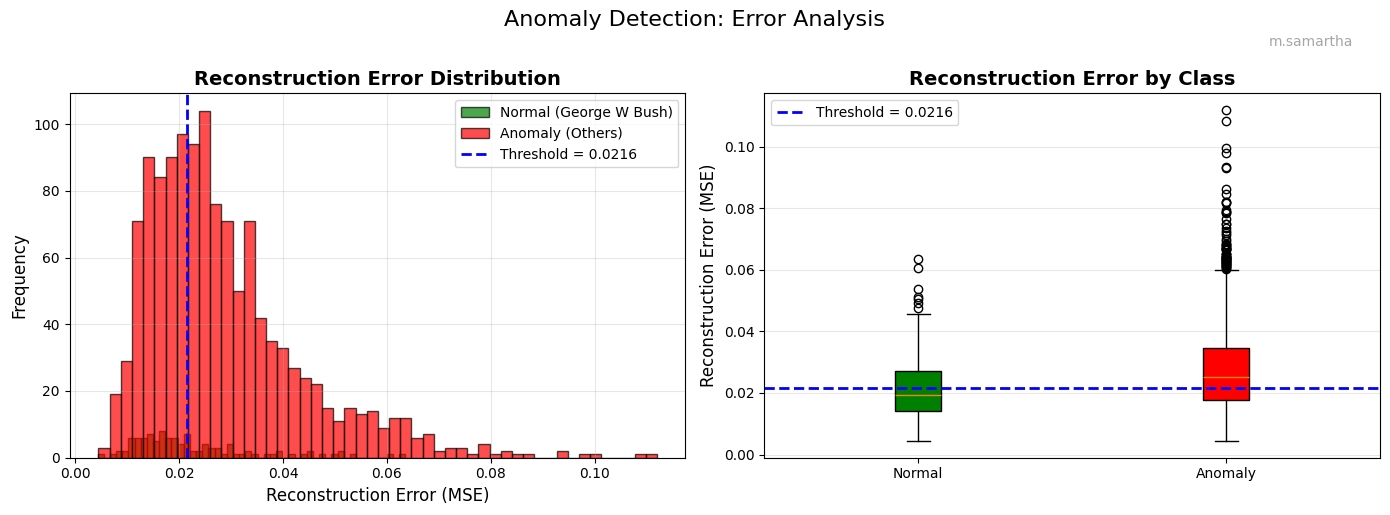

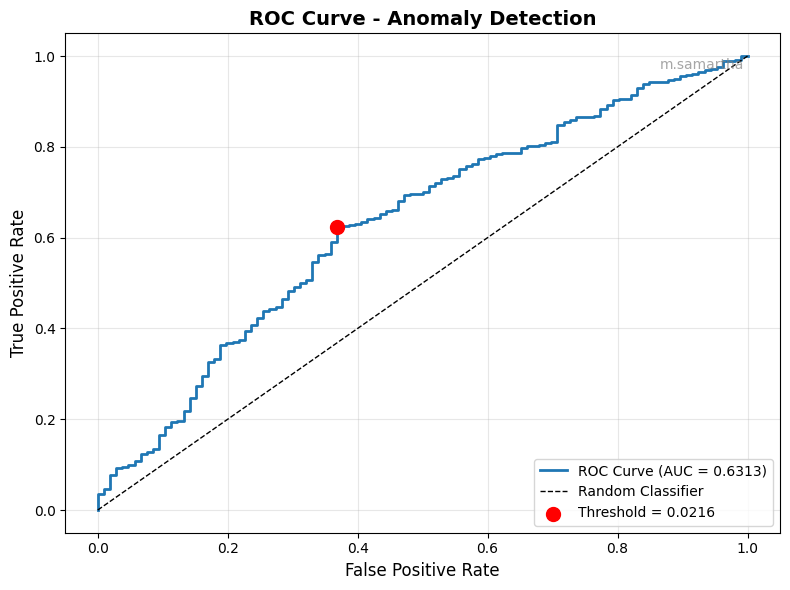

In [26]:
# Step 5: Visualize results
plot_error_distributions(reconstruction_errors, y_test, threshold)
plot_roc_curve(reconstruction_errors, y_test, metrics)

In [27]:
print(f"Metrics saved for further analysis:")
print(f"  - AUC: {metrics['auc_score']:.4f}")
print(f"  - F1-Score: {metrics['f1_score']:.4f}")

Metrics saved for further analysis:
  - AUC: 0.6313
  - F1-Score: 0.7539


### 3.2.2 Analysis and Visualization

#### Bottleneck Dimension Analysis

In [37]:
# Function to create an autoencoder with a specified bottleneck dimension
def create_autoencoder_with_bottleneck(input_size, bottleneck_dim):
    """
    Create an autoencoder with specified bottleneck dimension.
    Keeps the same architecture, only changes bottleneck size.
    
    Args:
        input_size: Input feature dimension
        bottleneck_dim: Bottleneck (latent) dimension
    
    Returns:
        autoencoder: MLPAutoencoder instance
    """
    # ENCODER: Gradually compress to bottleneck
    encoder_layers = [
        Linear(in_features=input_size, out_features=2500, activation=Tanh()),
        Linear(in_features=2500, out_features=1000, activation=Tanh()),
        Linear(in_features=1000, out_features=bottleneck_dim, activation=Tanh())
    ]
    
    # DECODER: Mirror encoder to reconstruct
    decoder_layers = [
        Linear(in_features=bottleneck_dim, out_features=1000, activation=Tanh()),
        Linear(in_features=1000, out_features=2500, activation=Tanh()),
        Linear(in_features=2500, out_features=input_size, activation=Sigmoid())
    ]
    
    # Create autoencoder
    autoencoder = MLPAutoencoder(encoder_layers, decoder_layers, loss_type='mse')
    
    return autoencoder

def train_and_evaluate_bottleneck(bottleneck_dim, X_train, X_test, y_test, 
                                   input_size, seed=42, verbose=True):
    """
    Train autoencoder with given bottleneck dimension and evaluate its performance.
    
    Args:
        bottleneck_dim: Bottleneck dimension to test
        X_train: Training data (normal class only)
        X_test: Test data (normal + anomalies)
        y_test: Test labels (0=normal, 1=anomaly)
        input_size: Input feature dimension
        seed: Random seed
        verbose: Whether to print detailed progress
    
    Returns:
        results: Dictionary containing all evaluation metrics and data
    """
    print(f"\n{'='*60}")
    print(f"BOTTLENECK DIMENSION: {bottleneck_dim}")
    print(f"{'='*60}")
    
    # Create autoencoder
    autoencoder = create_autoencoder_with_bottleneck(input_size, bottleneck_dim)
    
    # Train autoencoder
    run_folder = f"Q3/3_2/gwb_{bottleneck_dim}"
    print(f"\nTraining autoencoder...")
    autoencoder, final_loss, total_samples, duration = train_autoencoder(
        autoencoder=autoencoder,
        x_train=X_train,
        epochs=75,
        batch_size=106,
        learning_rate=5,
        patience=100,
        relative_loss_threshold=0.01,
        seed=seed,
        run_dir=run_folder
    )
    
    save_to(os.path.join(run_folder, f"autoencoder_gwb_{bottleneck_dim}.npz"), autoencoder)

    # Calculate reconstruction errors
    print(f"\nEvaluating on test set...")
    reconstruction_errors = calculate_reconstruction_errors(
        autoencoder, X_test, batch_size=256
    )
    
    # Find optimal threshold
    threshold = find_optimal_threshold(
        reconstruction_errors, y_test, method='youden'
    )
    
    # Evaluate performance
    metrics = evaluate_anomaly_detection(
        reconstruction_errors, y_test, threshold
    )
    
    # Print results
    if verbose:
        print_evaluation_report(metrics)
    
    # Store results
    results = {
        'bottleneck_dim': bottleneck_dim,
        'autoencoder': autoencoder,
        'run_folder': run_folder,
        'training_loss': final_loss,
        'training_time': duration,
        'reconstruction_errors': reconstruction_errors,
        'threshold': threshold,
        'auc_score': metrics['auc_score'],
        'precision': metrics['precision'],
        'recall': metrics['recall'],
        'f1_score': metrics['f1_score'],
        'tp': metrics['true_positives'],
        'fp': metrics['false_positives'],
        'tn': metrics['true_negatives'],
        'fn': metrics['false_negatives']
    }
    
    return results

def compare_bottleneck_dimensions(bottleneck_dims, X_train, X_test, y_test, 
                                   input_size, seed=42):
    """
    Train and evaluate autoencoders with different bottleneck dimensions.
    
    Args:
        bottleneck_dims: List of bottleneck dimensions to test
        X_train: Training data
        X_test: Test data
        y_test: Test labels
        input_size: Input feature dimension
        seed: Random seed
    
    Returns:
        all_results: List of result dictionaries for each bottleneck dimension
    """
    all_results = []
    
    print(f"\n{'#'*60}")
    print(f"BOTTLENECK DIMENSION ANALYSIS")
    print(f"Testing dimensions: {bottleneck_dims}")
    print(f"{'#'*60}")
    
    for bottleneck_dim in bottleneck_dims:
        results = train_and_evaluate_bottleneck(
            bottleneck_dim=bottleneck_dim,
            X_train=X_train,
            X_test=X_test,
            y_test=y_test,
            input_size=input_size,
            seed=seed,
            verbose=False  # Set to True for detailed output
        )
        all_results.append(results)
    
    return all_results

Input size: 62500
Testing bottleneck dimensions: [64, 256]

############################################################
BOTTLENECK DIMENSION ANALYSIS
Testing dimensions: [64, 256]
############################################################

BOTTLENECK DIMENSION: 64

Training autoencoder...


Training: 100%|██████████| 75/75 [29:48<00:00, 23.85s/epoch, loss=0.0222]


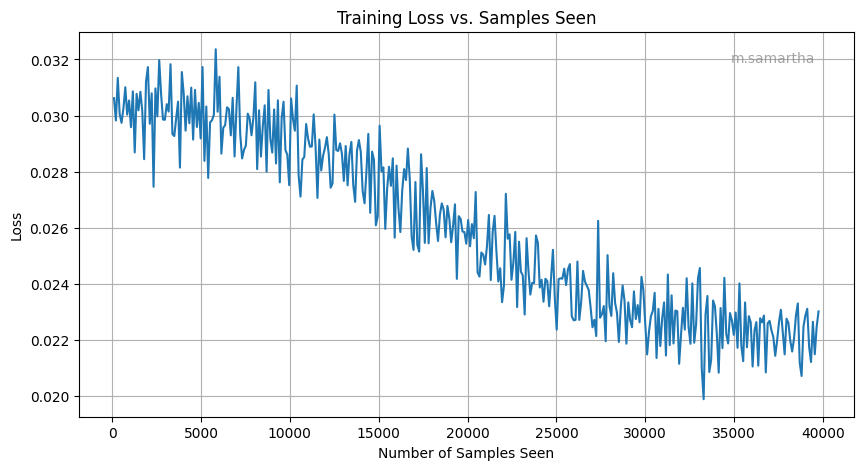

Loss plot saved to Q3/3_2/gwb_64/loss_plot.png

Training completed in 1788.51 seconds
Final loss: 0.022158
Total samples seen: 39750
Autoencoder saved to Q3/3_2/gwb_64/autoencoder_gwb_64.npz

Evaluating on test set...
Calculating reconstruction errors in batches of 256...
  Processed 256/1376 images...
Reconstruction errors calculated for 1376 images
  Min error: 0.004343
  Max error: 0.111810
  Mean error: 0.028129

Optimal threshold (Youden's J): 0.021806
  TPR at threshold: 0.619
  FPR at threshold: 0.368

BOTTLENECK DIMENSION: 256

Training autoencoder...


Training: 100%|██████████| 75/75 [29:55<00:00, 23.94s/epoch, loss=0.0220]


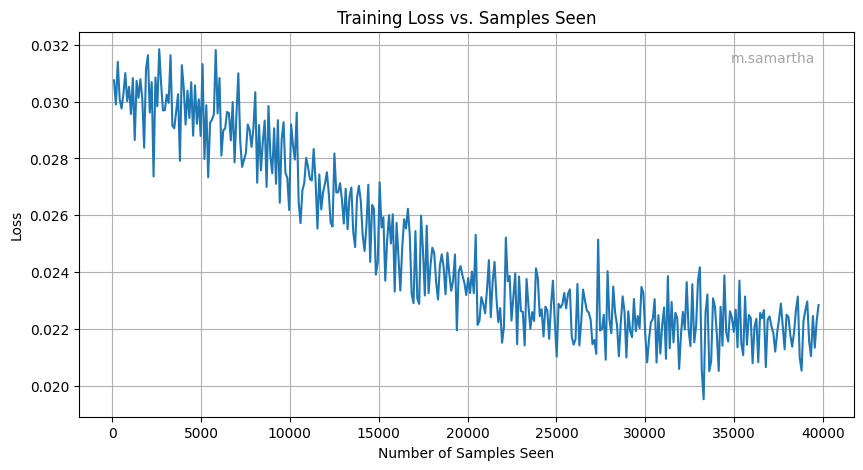

Loss plot saved to Q3/3_2/gwb_256/loss_plot.png

Training completed in 1795.88 seconds
Final loss: 0.021988
Total samples seen: 39750
Autoencoder saved to Q3/3_2/gwb_256/autoencoder_gwb_256.npz

Evaluating on test set...
Calculating reconstruction errors in batches of 256...
  Processed 256/1376 images...
Reconstruction errors calculated for 1376 images
  Min error: 0.004359
  Max error: 0.111747
  Mean error: 0.028037

Optimal threshold (Youden's J): 0.021604
  TPR at threshold: 0.620
  FPR at threshold: 0.368


In [38]:
# Define bottleneck dimensions to test
bottleneck_dimensions = [64, 256]  # You can modify this list

# Get input size from data
input_size = X_train.shape[1]  # Should be 11750 for LFW

print(f"Input size: {input_size}")
print(f"Testing bottleneck dimensions: {bottleneck_dimensions}")

# Run comparison
all_results = compare_bottleneck_dimensions(
    bottleneck_dims=bottleneck_dimensions,
    X_train=X_train,
    X_test=X_test,
    y_test=y_test,
    input_size=input_size,
    seed=seed
)

In [40]:
def plot_bottleneck_comparison(all_results):
    """
    Plot comparison of different bottleneck dimensions.
    
    Args:
        all_results: List of result dictionaries from compare_bottleneck_dimensions
    """
    bottleneck_dims = [r['bottleneck_dim'] for r in all_results]
    auc_scores = [r['auc_score'] for r in all_results]
    f1_scores = [r['f1_score'] for r in all_results]
    precisions = [r['precision'] for r in all_results]
    recalls = [r['recall'] for r in all_results]
    training_times = [r['training_time'] for r in all_results]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: AUC vs Bottleneck Dimension
    axes[0, 0].plot(bottleneck_dims, auc_scores, 'o-', linewidth=2, markersize=8, color='blue')
    axes[0, 0].set_xlabel('Bottleneck Dimension', fontsize=11)
    axes[0, 0].set_ylabel('AUC Score', fontsize=11)
    axes[0, 0].set_title('AUC Score vs Bottleneck Dimension', fontsize=12, fontweight='bold')
    axes[0, 0].grid(alpha=0.3)
    # axes[0, 0].set_ylim([0.8, 1.0])
    
    # Plot 2: F1, Precision, Recall vs Bottleneck Dimension
    axes[0, 1].plot(bottleneck_dims, f1_scores, 'o-', linewidth=2, markersize=8, 
                    label='F1-Score', color='green')
    axes[0, 1].plot(bottleneck_dims, precisions, 's-', linewidth=2, markersize=8, 
                    label='Precision', color='orange')
    axes[0, 1].plot(bottleneck_dims, recalls, '^-', linewidth=2, markersize=8, 
                    label='Recall', color='red')
    axes[0, 1].set_xlabel('Bottleneck Dimension', fontsize=11)
    axes[0, 1].set_ylabel('Score', fontsize=11)
    axes[0, 1].set_title('Performance Metrics vs Bottleneck Dimension', fontsize=12, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    # axes[0, 1].set_ylim([0.7, 1.0])
    
    # Plot 3: Training Time vs Bottleneck Dimension
    axes[1, 0].bar(range(len(bottleneck_dims)), training_times, 
                   tick_label=bottleneck_dims, color='purple', alpha=0.7, edgecolor='black')
    axes[1, 0].set_xlabel('Bottleneck Dimension', fontsize=11)
    axes[1, 0].set_ylabel('Training Time (seconds)', fontsize=11)
    axes[1, 0].set_title('Training Time vs Bottleneck Dimension', fontsize=12, fontweight='bold')
    axes[1, 0].grid(alpha=0.3, axis='y')
    
    # Plot 4: Summary Table
    axes[1, 1].axis('off')
    table_data = []
    for r in all_results:
        table_data.append([
            r['bottleneck_dim'],
            f"{r['auc_score']:.4f}",
            f"{r['f1_score']:.4f}",
            f"{r['precision']:.4f}",
            f"{r['recall']:.4f}"
        ])
    
    table = axes[1, 1].table(
        cellText=table_data,
        colLabels=['Bottleneck', 'AUC', 'F1', 'Precision', 'Recall'],
        loc='center',
        cellLoc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Style header
    for i in range(5):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    axes[1, 1].set_title('Performance Summary', fontsize=12, fontweight='bold')
    
    plt.suptitle('Bottleneck Dimension Analysis', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0, 0.03, 1, 0.99])
    add_username_fig(fig=fig)    
    plt.show()

In [41]:
def plot_roc_curves_comparison(all_results, y_test):
    """
    Plot ROC curves for all bottleneck dimensions on a single graph.
    
    Args:
        all_results: List of result dictionaries
        y_test: True test labels
    """
    plt.figure(figsize=(10, 8))
    
    colors = ['blue', 'green', 'red', 'purple', 'orange']
    
    for i, results in enumerate(all_results):
        reconstruction_errors = results['reconstruction_errors']
        fpr, tpr, _ = roc_curve(y_test, reconstruction_errors)
        auc_score = results['auc_score']
        bottleneck_dim = results['bottleneck_dim']
        
        plt.plot(fpr, tpr, linewidth=2.5, 
                label=f'Bottleneck={bottleneck_dim} (AUC={auc_score:.4f})',
                color=colors[i % len(colors)])
    
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier')
    
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves - Bottleneck Dimension Comparison', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(alpha=0.3)
    add_username()    
    plt.tight_layout()
    plt.show()


In [43]:
reconstruction_errors = calculate_reconstruction_errors(
        autoencoder_gwb_128, X_test, batch_size=256
    )
    
# Find optimal threshold
threshold = find_optimal_threshold(
    reconstruction_errors, y_test, method='youden'
)
    
# Evaluate performance
metrics = evaluate_anomaly_detection(
    reconstruction_errors, y_test, threshold
)
    
print_evaluation_report(metrics)
    
# Store results
results = {
    'bottleneck_dim': 128,
    'autoencoder': autoencoder_gwb_128,
    'run_folder': 'Q3/3_2/gwb_128',
    'training_loss': final_loss_gwb_128,
    'training_time': duration_gwb_128,
    'reconstruction_errors': reconstruction_errors,
    'threshold': threshold,
    'auc_score': metrics['auc_score'],
    'precision': metrics['precision'],
    'recall': metrics['recall'],
    'f1_score': metrics['f1_score'],
    'tp': metrics['true_positives'],
    'fp': metrics['false_positives'],
    'tn': metrics['true_negatives'],
    'fn': metrics['false_negatives']
}

all_results.insert(1, results)

Calculating reconstruction errors in batches of 256...
  Processed 256/1376 images...
Reconstruction errors calculated for 1376 images
  Min error: 0.004339
  Max error: 0.112038
  Mean error: 0.028116

Optimal threshold (Youden's J): 0.021621
  TPR at threshold: 0.624
  FPR at threshold: 0.368

ANOMALY DETECTION EVALUATION REPORT

Classification Threshold: 0.021621

Metric               Value     
------------------------------
AUC Score            0.6313
Precision            0.9531
Recall               0.6236
F1-Score             0.7539

Confusion Matrix    
------------------------------
True Positives       792       
False Positives      39        
True Negatives       67        
False Negatives      478       



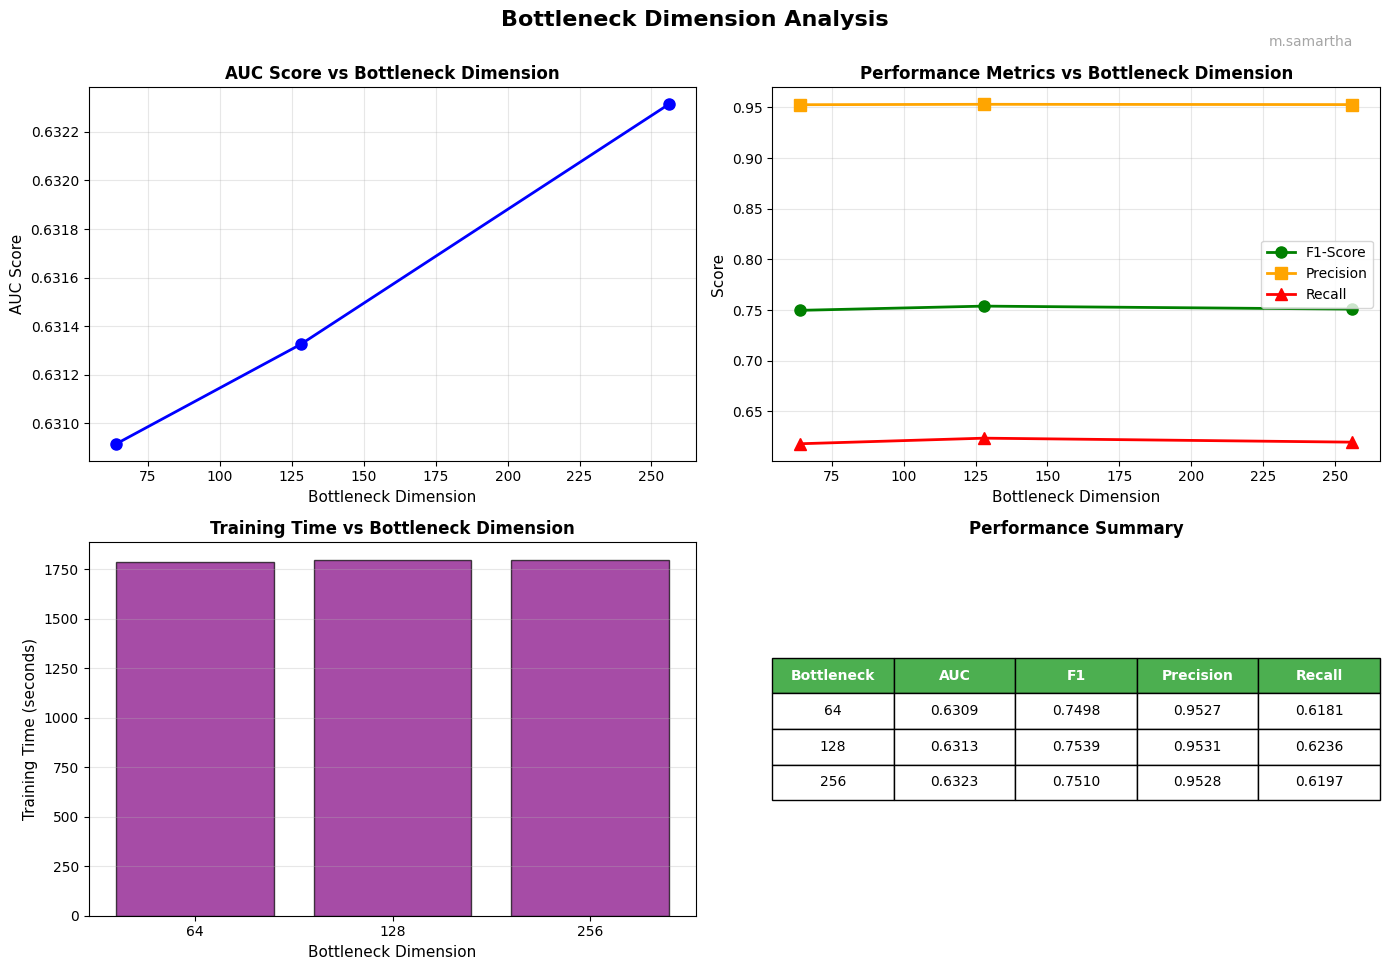

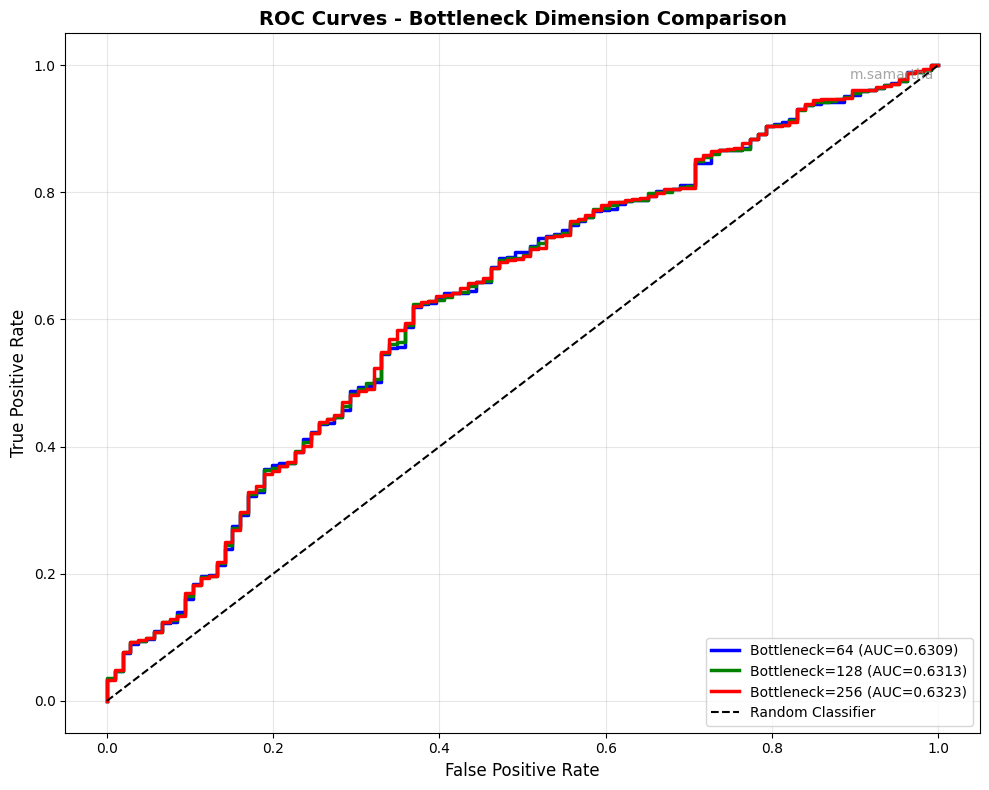


FINAL SUMMARY

Bottleneck Dimension: 64
  AUC Score: 0.6309
  F1-Score: 0.7498
  Training Time: 1788.51s

Bottleneck Dimension: 128
  AUC Score: 0.6313
  F1-Score: 0.7539
  Training Time: 1795.64s

Bottleneck Dimension: 256
  AUC Score: 0.6323
  F1-Score: 0.7510
  Training Time: 1795.88s


In [44]:
# Plot comparisons
plot_bottleneck_comparison(all_results)
plot_roc_curves_comparison(all_results, y_test)

# Print final summary
print(f"\n{'='*60}")
print(f"FINAL SUMMARY")
print(f"{'='*60}")
for results in all_results:
    print(f"\nBottleneck Dimension: {results['bottleneck_dim']}")
    print(f"  AUC Score: {results['auc_score']:.4f}")
    print(f"  F1-Score: {results['f1_score']:.4f}")
    print(f"  Training Time: {results['training_time']:.2f}s")

In [45]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

In [57]:
def find_classification_examples(X_test, y_test, y_pred, reconstruction_errors, img_shape):
    """
    Find examples of each classification type.
    
    Args:
        X_test: Test images
        y_test: True labels (0=normal, 1=anomaly)
        y_pred: Predicted labels (0=normal, 1=anomaly)
        reconstruction_errors: Reconstruction error for each image
        img_shape: Tuple (height, width) for reshaping images
    
    Returns:
        examples: Dictionary with indices for TN, TP, FP, FN
    """
    # True Negative: Predicted normal (0), Actually normal (0)
    tn_indices = np.where((y_pred == 0) & (y_test == 0))[0]
    
    # True Positive: Predicted anomaly (1), Actually anomaly (1)
    tp_indices = np.where((y_pred == 1) & (y_test == 1))[0]
    
    # False Positive: Predicted anomaly (1), Actually normal (0)
    fp_indices = np.where((y_pred == 1) & (y_test == 0))[0]
    
    # False Negative: Predicted normal (0), Actually anomaly (1)
    fn_indices = np.where((y_pred == 0) & (y_test == 1))[0]
    
    examples = {
        'TN': tn_indices[0] if len(tn_indices) > 0 else None,
        'TP': tp_indices[0] if len(tp_indices) > 0 else None,
        'FP': fp_indices[0] if len(fp_indices) > 0 else None,
        'FN': fn_indices[0] if len(fn_indices) > 0 else None,
        'TN_error': reconstruction_errors[tn_indices[0]] if len(tn_indices) > 0 else None,
        'TP_error': reconstruction_errors[tp_indices[0]] if len(tp_indices) > 0 else None,
        'FP_error': reconstruction_errors[fp_indices[0]] if len(fp_indices) > 0 else None,
        'FN_error': reconstruction_errors[fn_indices[0]] if len(fn_indices) > 0 else None,
    }
    
    print(f"Found examples:")
    print(f"  True Negatives: {len(tn_indices)}")
    print(f"  True Positives: {len(tp_indices)}")
    print(f"  False Positives: {len(fp_indices)}")
    print(f"  False Negatives: {len(fn_indices)}")
    
    return examples

In [58]:
def visualize_classification_examples(autoencoder, X_test, examples, threshold, img_shape):
    """
    Visualize examples of all classification types.
    
    Args:
        autoencoder: Trained autoencoder model
        X_test: Test images
        examples: Dictionary with indices for each classification type
        threshold: Classification threshold
        img_shape: Tuple (height, width) for reshaping images
    """
    fig = plt.figure(figsize=(10, 10))
    
    # Define layout: 4 rows (TN, TP, FP, FN) x 3 columns (Original, Reconstruction, Error Map)
    categories = [
        ('TN', 'True Negative\n(Correctly Identified Normal)', 'green'),
        ('TP', 'True Positive\n(Correctly Identified Anomaly)', 'green'),
        ('FP', 'False Positive\n(Normal Misclassified as Anomaly)', 'red'),
        ('FN', 'False Negative\n(Anomaly Misclassified as Normal)', 'red')
    ]
    
    for row, (cat_key, cat_name, color) in enumerate(categories):
        idx = examples[cat_key]
        error = examples[f'{cat_key}_error']
        
        if idx is None:
            continue
        
        # Get original and reconstruction
        original = X_test[idx].reshape(img_shape)
        reconstructed = autoencoder.forward(X_test[idx:idx+1].T).T.reshape(img_shape)
        
        # Calculate pixel-wise error map
        error_map = np.abs(original - reconstructed)
        
        # Column 1: Original Image
        ax1 = plt.subplot(4, 3, row * 3 + 1)
        ax1.imshow(original, cmap='gray')
        ax1.set_title(f'{cat_name}\nOriginal', fontsize=10, fontweight='bold', color=color)
        ax1.axis('off')
        
        # Column 2: Reconstruction
        ax2 = plt.subplot(4, 3, row * 3 + 2)
        ax2.imshow(reconstructed, cmap='gray')
        ax2.set_title(f'Reconstruction\nError: {error:.6f}', fontsize=10)
        ax2.axis('off')
        
        # Column 3: Error Map
        ax3 = plt.subplot(4, 3, row * 3 + 3)
        im = ax3.imshow(error_map, cmap='hot')
        ax3.set_title(f'Error Map\n(Threshold: {threshold:.6f})', fontsize=10)
        ax3.axis('off')
        plt.colorbar(im, ax=ax3, fraction=0.046)
    
    plt.suptitle('Anomaly Detection: Classification Examples', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    add_username_fig(fig=fig)
    plt.show()


In [59]:
def plot_precision_recall_curve(reconstruction_errors, y_test, threshold=None):
    """
    Plot Precision-Recall curve.
    
    Args:
        reconstruction_errors: Reconstruction errors for test set
        y_test: True labels (0=normal, 1=anomaly)
        threshold: Optional threshold to mark on the curve
    """
    # Calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, reconstruction_errors)
    
    # Calculate Average Precision (area under PR curve)
    avg_precision = average_precision_score(y_test, reconstruction_errors)
    
    # Calculate PR-AUC (area under curve)
    pr_auc = auc(recall, precision)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    ax.plot(recall, precision, linewidth=2.5, color='blue',
            label=f'PR Curve (AP={avg_precision:.4f}, AUC={pr_auc:.4f})')
    
    # Mark threshold point if provided
    if threshold is not None:
        # Find the point on the curve closest to the threshold
        threshold_idx = np.argmin(np.abs(thresholds - threshold))
        ax.scatter(recall[threshold_idx], precision[threshold_idx], 
                  color='red', s=200, zorder=5, marker='*',
                  label=f'Threshold={threshold:.4f}')
    
    # Baseline (random classifier)
    baseline = np.sum(y_test == 1) / len(y_test)  # Proportion of anomalies
    ax.axhline(y=baseline, color='gray', linestyle='--', linewidth=1.5,
               label=f'Random Classifier (baseline={baseline:.3f})')
    
    ax.set_xlabel('Recall (Sensitivity)', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_title('Precision-Recall Curve - Anomaly Detection', fontsize=14, fontweight='bold')
    ax.legend(loc='lower left', fontsize=11)
    ax.grid(alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0.75, 1])
    add_username_fig(fig=fig)
    plt.tight_layout()
    plt.show()
    
    return avg_precision, pr_auc

In [60]:
def comprehensive_visualization(autoencoder, X_test, y_test, reconstruction_errors, 
                                threshold, y_pred, img_shape=(250, 250)):
    """
    Complete visualization pipeline for anomaly detection results.
    
    Args:
        autoencoder: Trained autoencoder model
        X_test: Test images
        y_test: True labels
        reconstruction_errors: Reconstruction errors
        threshold: Classification threshold
        y_pred: Predicted labels
        img_shape: Image dimensions (height, width)
    """
    print(f"\n{'='*60}")
    print(f"COMPREHENSIVE VISUALIZATION")
    print(f"{'='*60}\n")
    
    # 1. Find classification examples
    print("Step 1: Finding classification examples...")
    examples = find_classification_examples(X_test, y_test, y_pred, 
                                           reconstruction_errors, img_shape)
    
    # 2. Visualize classification examples
    print("\nStep 2: Visualizing classification examples...")
    visualize_classification_examples(autoencoder, X_test, examples, 
                                     threshold, img_shape)
    
    # 3. Plot Precision-Recall curve
    print("\nStep 3: Plotting Precision-Recall curve...")
    avg_precision, pr_auc = plot_precision_recall_curve(reconstruction_errors, 
                                                        y_test, threshold)
    
    print(f"\nPR Curve Metrics:")
    print(f"  Average Precision: {avg_precision:.4f}")
    print(f"  PR-AUC: {pr_auc:.4f}")
    
    return examples, avg_precision, pr_auc


COMPREHENSIVE VISUALIZATION

Step 1: Finding classification examples...
Found examples:
  True Negatives: 67
  True Positives: 787
  False Positives: 39
  False Negatives: 483

Step 2: Visualizing classification examples...


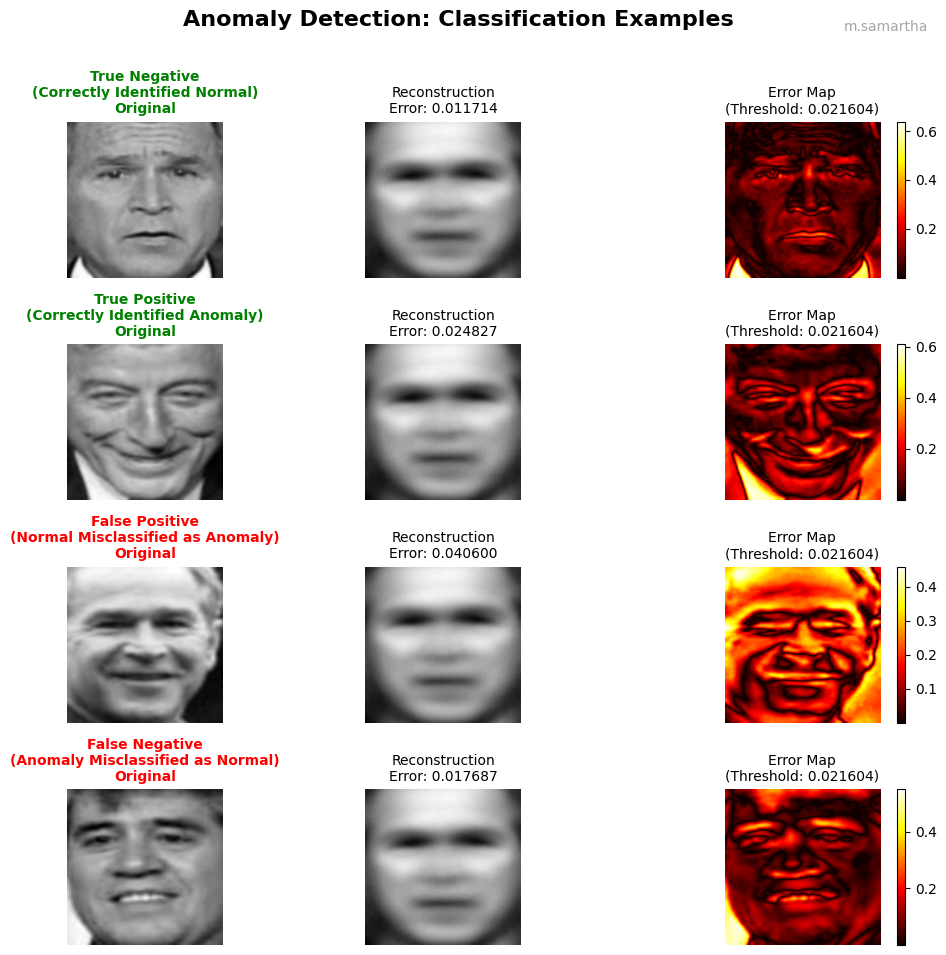


Step 3: Plotting Precision-Recall curve...


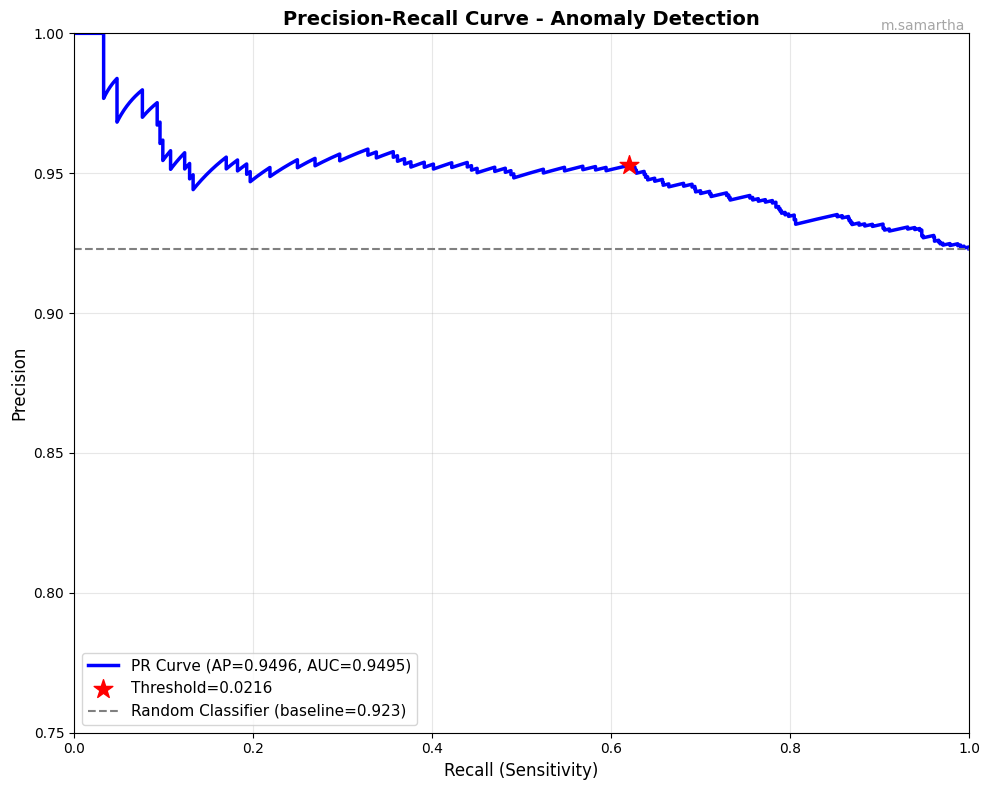


PR Curve Metrics:
  Average Precision: 0.9496
  PR-AUC: 0.9495


In [61]:
best_result = all_results[2]  # Change index based on your results
best_autoencoder = best_result['autoencoder']
best_threshold = best_result['threshold']
best_reconstruction_errors = best_result['reconstruction_errors']

# Get predictions
y_pred = (best_reconstruction_errors > best_threshold).astype(int)

# Image shape for LFW
img_shape = (250, 250)  # height, width

# Run comprehensive visualization
examples, avg_precision, pr_auc = comprehensive_visualization(
    autoencoder=best_autoencoder,
    X_test=X_test,
    y_test=y_test,
    reconstruction_errors=best_reconstruction_errors,
    threshold=best_threshold,
    y_pred=y_pred,
    img_shape=img_shape
)

In [52]:
def create_detailed_comparison_grid(autoencoder, X_test, y_test, reconstruction_errors,
                                    threshold, y_pred, img_shape=(250, 250), n_examples=3):
    """
    Create a detailed grid showing multiple examples of each classification type.
    
    Args:
        autoencoder: Trained autoencoder
        X_test: Test images
        y_test: True labels
        reconstruction_errors: Reconstruction errors
        threshold: Classification threshold
        y_pred: Predicted labels
        img_shape: Image dimensions
        n_examples: Number of examples per category
    """
    # Get indices for each category
    tn_indices = np.where((y_pred == 0) & (y_test == 0))[0][:n_examples]
    tp_indices = np.where((y_pred == 1) & (y_test == 1))[0][:n_examples]
    fp_indices = np.where((y_pred == 1) & (y_test == 0))[0][:n_examples]
    fn_indices = np.where((y_pred == 0) & (y_test == 1))[0][:n_examples]
    
    fig, axes = plt.subplots(4, n_examples * 2, figsize=(16, 10))
    
    categories = [
        (tn_indices, 'True Negative', 'green'),
        (tp_indices, 'True Positive', 'green'),
        (fp_indices, 'False Positive', 'red'),
        (fn_indices, 'False Negative', 'red')
    ]
    
    for row, (indices, cat_name, color) in enumerate(categories):
        for col, idx in enumerate(indices):
            # Original
            ax_orig = axes[row, col * 2]
            ax_orig.imshow(X_test[idx].reshape(img_shape), cmap='gray')
            ax_orig.axis('off')
            if col == 0:
                ax_orig.set_title(f'{cat_name}\nOriginal', 
                                fontsize=9, fontweight='bold', color=color)
            else:
                ax_orig.set_title('Original', fontsize=9)
            
            # Reconstruction
            ax_recon = axes[row, col * 2 + 1]
            reconstructed = autoencoder.forward(X_test[idx:idx+1].T).T.reshape(img_shape)
            ax_recon.imshow(reconstructed, cmap='gray')
            ax_recon.axis('off')
            error = reconstruction_errors[idx]
            ax_recon.set_title(f'Recon\nErr:{error:.4f}', fontsize=9)
    
    plt.suptitle(f'Classification Examples Grid (Threshold={threshold:.4f})', 
                fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    add_username_fig(fig=fig)
    plt.show()


Creating detailed comparison grid...


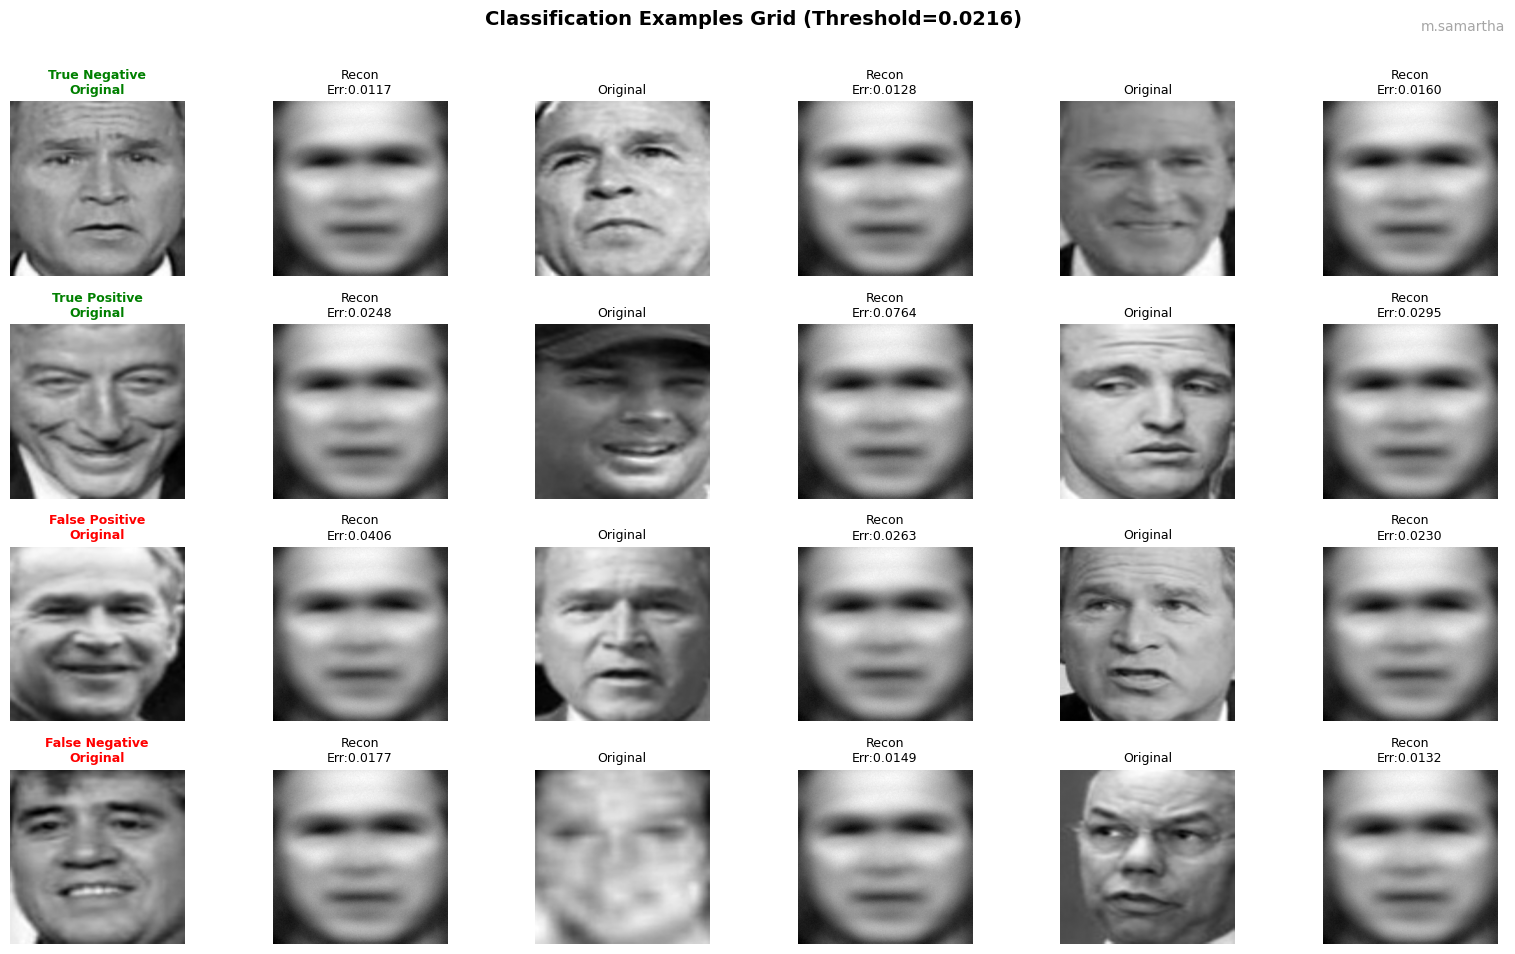

In [63]:
# Create detailed comparison grid with multiple examples
print("\nCreating detailed comparison grid...")
create_detailed_comparison_grid(
    autoencoder=best_autoencoder,
    X_test=X_test,
    y_test=y_test,
    reconstruction_errors=best_reconstruction_errors,
    threshold=best_threshold,
    y_pred=y_pred,
    img_shape=img_shape,
    n_examples=3
)